# Notes
- distance can be removed
- incorrect because class is not balanced
- also incorrect because one hot encoding is used in entire dataset, should only be applied to training

In [1]:
import numpy as np
import pandas as pd
import sqlite3
from sqlite3 import Error
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
### download the db from link in readme
db_path = "../../dbs/delays_new.db"

In [3]:
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        connection.text_factory = str
    except Error as e:
        print("Error occurred: " + str(e))
    return connection


def execute_query(connection, query):
    cursor = connection.cursor()
    try:
        if query == "":
            return "Query Blank"
        else:
            df = pd.read_sql_query(query, connection)
            return df
    except Error as e:
        return "Error occurred: " + str(e)

In [4]:
def onehot_encode(df, column_dict):
    df = df.copy()
    for column, prefix in column_dict.items():
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

In [5]:
def preprocess_inputs(df):
    df = df.copy()
    
    y = (df.ArrDelay>15).astype(int)
    
    
    df = df[['Year',
     'Month',
     'DayofMonth',
     'DayOfWeek',
     'IATA_CODE_Reporting_Airline',
     'OriginAirportID',
     'DestAirportID',
     'AirTime',
     'Distance',
    ]]
    

    
    # One-hot encode nominal feature columns
    X = onehot_encode(
        df,
        column_dict={
            'IATA_CODE_Reporting_Airline': 'AL',
            'OriginAirportID': 'OA',
            'DestAirportID': 'DA',
            'Year': 'Y',
            'Month': 'M',
            'DayofMonth': 'DM',
            'DayOfWeek': 'DW'
        }
    )
    

    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
    
    # Scale X with a standard scaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
   
    return X_train, X_test, y_train, y_test

In [6]:
def evaluate_model(model, X_test, y_test):
    
    model_acc = model.score(X_test, y_test)
    print("Test Accuracy: {:.2f}%".format(model_acc * 100))
    
    y_true = np.array(y_test)
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_true, y_pred)
    clr = classification_report(y_true, y_pred, target_names=["Not Delayed", "Delayed"])
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(2) + 0.5, ["Not Delayed", "Delayed"])
    plt.yticks(np.arange(2) + 0.5, ["Not Delayed", "Delayed"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

In [7]:
sample_query = \
    """
        select 
         *
        from 
          delay 
        where 
          year = 2018
          and Cancelled = 0
        order by RANDOM() LIMIT 1000000
    """

connection = create_connection(db_path)
data =  execute_query(connection, sample_query)

In [8]:
data

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,...,CRSElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2018,1,1,18,4,2018-01-18,19393,WN,N430WN,6384,...,140,153,133,1,986,0,0,13,0,6
1,2018,3,9,19,3,2018-09-19,19393,WN,N8705Q,856,...,100,109,80,1,528,0,0,0,0,0
2,2018,4,11,2,5,2018-11-02,19930,AS,N570AS,451,...,141,156,134,1,873,0,0,0,0,0
3,2018,2,6,20,3,2018-06-20,20366,EV,N29917,4309,...,146,138,108,1,788,0,0,0,0,0
4,2018,4,12,11,2,2018-12-11,20452,YX,N114HQ,4462,...,114,110,93,1,634,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2018,2,5,30,3,2018-05-30,20397,OH,N249PS,5384,...,128,112,87,1,564,0,0,0,0,0
999996,2018,4,12,8,6,2018-12-08,19790,DL,N3773D,2971,...,89,88,72,1,337,0,0,0,0,0
999997,2018,3,7,23,1,2018-07-23,19805,AA,N732US,1909,...,86,74,48,1,257,0,13,0,0,94
999998,2018,4,11,16,5,2018-11-16,19790,DL,N922DL,1803,...,94,83,56,1,356,18,0,0,0,8


In [9]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)

In [10]:
X_train

,AirTime,Distance,AL_9E,AL_AA,AL_AS,AL_B6,AL_DL,AL_EV,AL_F9,AL_G4,...,DM_29,DM_30,DM_31,DW_1,DW_2,DW_3,DW_4,DW_5,DW_6,DW_7
0,-0.114473,-0.093368,-0.186987,-0.380754,-0.188329,-0.210274,2.543512,-0.169257,-0.129651,-0.117595,...,-0.178543,5.599819,-0.138254,-0.421088,-0.408755,-0.410898,-0.417077,-0.417789,2.679313,-0.408029
1,-0.550005,-0.574485,-0.186987,-0.380754,-0.188329,-0.210274,-0.393157,5.908184,-0.129651,-0.117595,...,-0.178543,-0.178577,-0.138254,-0.421088,-0.408755,-0.410898,-0.417077,2.393551,-0.373230,-0.408029
2,-0.788845,-0.721493,-0.186987,-0.380754,-0.188329,-0.210274,-0.393157,-0.169257,-0.129651,-0.117595,...,-0.178543,-0.178577,-0.138254,-0.421088,-0.408755,2.433697,-0.417077,-0.417789,-0.373230,-0.408029
3,-0.156621,-0.338938,-0.186987,-0.380754,-0.188329,-0.210274,-0.393157,-0.169257,-0.129651,-0.117595,...,-0.178543,-0.178577,-0.138254,-0.421088,-0.408755,2.433697,-0.417077,-0.417789,-0.373230,-0.408029
4,0.292961,0.618285,-0.186987,-0.380754,-0.188329,-0.210274,-0.393157,-0.169257,-0.129651,-0.117595,...,-0.178543,-0.178577,-0.138254,-0.421088,2.446451,-0.410898,-0.417077,-0.417789,-0.373230,-0.408029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699995,-0.592153,-0.594531,-0.186987,-0.380754,-0.188329,-0.210274,-0.393157,-0.169257,-0.129651,-0.117595,...,-0.178543,-0.178577,-0.138254,-0.421088,2.446451,-0.410898,-0.417077,-0.417789,-0.373230,-0.408029
699996,-0.465708,-0.626272,-0.186987,-0.380754,-0.188329,-0.210274,-0.393157,5.908184,-0.129651,-0.117595,...,-0.178543,-0.178577,-0.138254,-0.421088,-0.408755,-0.410898,-0.417077,-0.417789,-0.373230,2.450805
699997,-0.830994,-0.866830,-0.186987,-0.380754,-0.188329,-0.210274,-0.393157,-0.169257,-0.129651,-0.117595,...,-0.178543,-0.178577,-0.138254,-0.421088,-0.408755,2.433697,-0.417077,-0.417789,-0.373230,-0.408029
699998,2.021041,1.662376,-0.186987,-0.380754,-0.188329,-0.210274,-0.393157,-0.169257,-0.129651,-0.117595,...,-0.178543,-0.178577,-0.138254,2.374798,-0.408755,-0.410898,-0.417077,-0.417789,-0.373230,-0.408029


In [11]:
clf = LogisticRegression(random_state=42).fit(X_train, y_train)

Test Accuracy: 82.18%


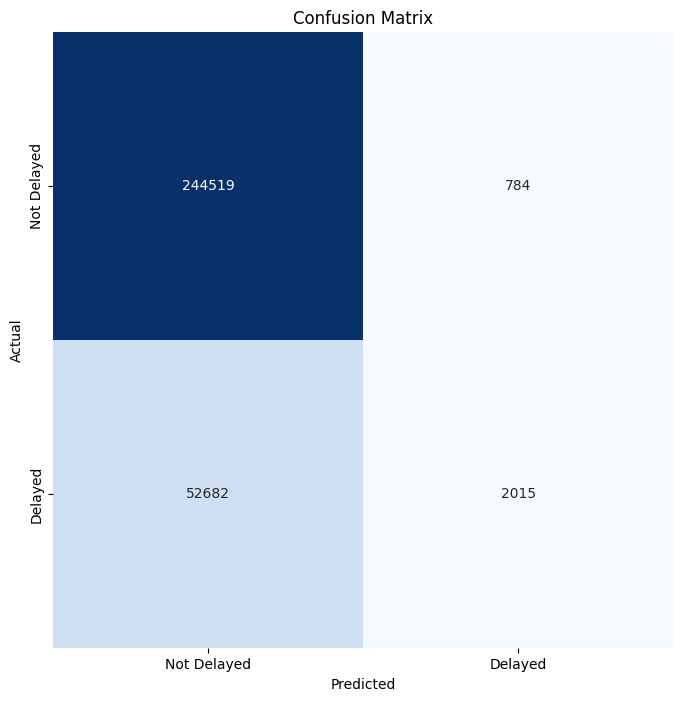

Classification Report:
----------------------
               precision    recall  f1-score   support

 Not Delayed       0.82      1.00      0.90    245303
     Delayed       0.72      0.04      0.07     54697

    accuracy                           0.82    300000
   macro avg       0.77      0.52      0.49    300000
weighted avg       0.80      0.82      0.75    300000



In [12]:
evaluate_model(clf, X_test, y_test)

In [13]:
clf_rf = RandomForestClassifier(n_estimators = 100) 
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf_rf.fit(X_train, y_train)
 

RandomForestClassifier()

Test Accuracy: 80.67%


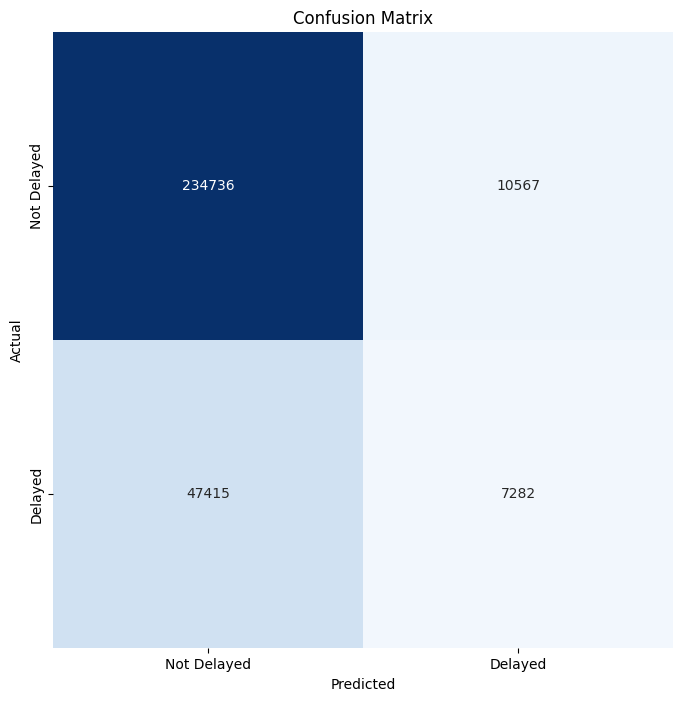

Classification Report:
----------------------
               precision    recall  f1-score   support

 Not Delayed       0.83      0.96      0.89    245303
     Delayed       0.41      0.13      0.20     54697

    accuracy                           0.81    300000
   macro avg       0.62      0.55      0.55    300000
weighted avg       0.75      0.81      0.76    300000



In [14]:
evaluate_model(clf_rf, X_test, y_test)